In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from sklearn.decomposition import PCA
from src.feature_extraction import scale_density, split_data, scale_population_curves
from src.cluster_data import *
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import yaml

# Density

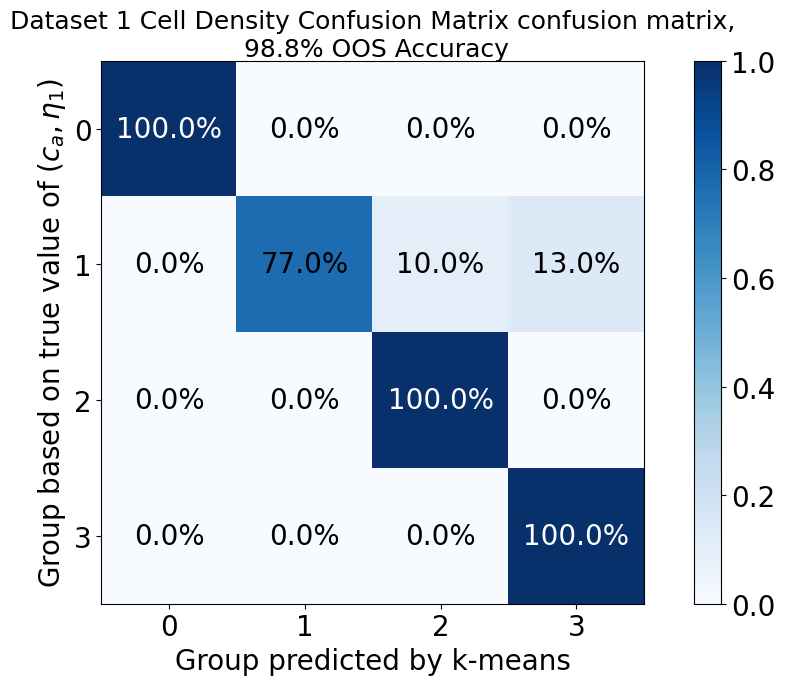

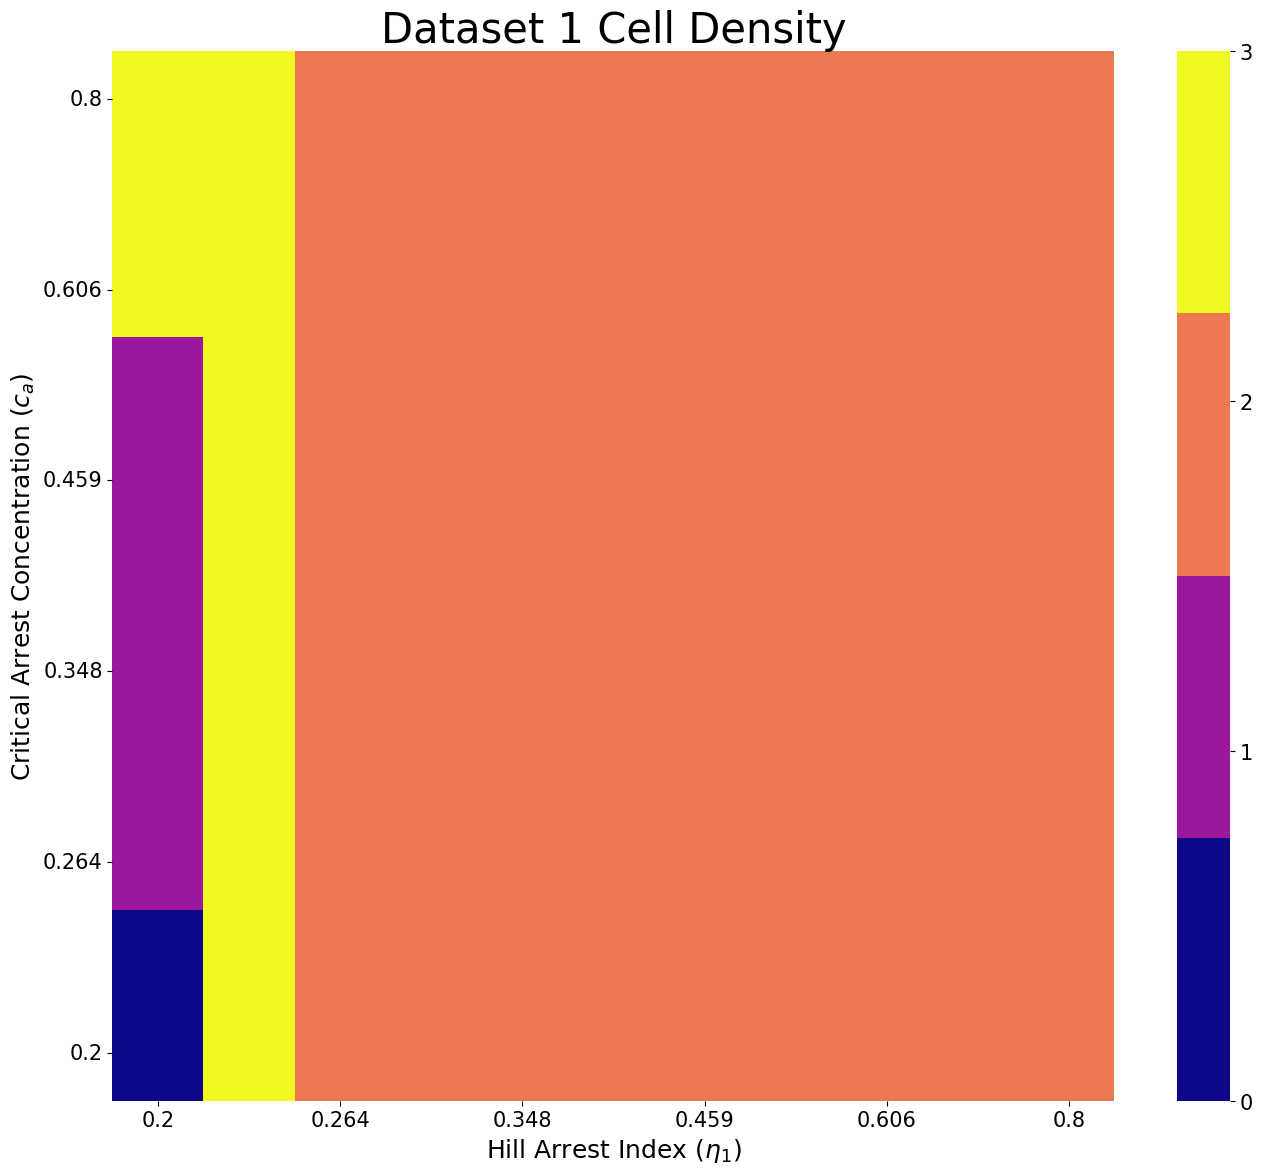

In [2]:

## Load, Split, Scale data
density = np.load("../data/dataset1/density.npy", allow_pickle=True)
density_train, density_test = split_data(density, itr_cutoff = 5)

density_train = scale_density(density_train).reshape((605,40000))
density_test = scale_density(density_test).reshape((605,40000))


## Reduce dimensions to 3
density_pca = PCA(n_components = 3, random_state = 0)
density_pca.fit(density_train)
density_train_reduced = density_pca.transform(density_train)
density_test_reduced = density_pca.transform(density_test)


# Cluster
density_kmeans = KMeans(n_clusters = 4,n_init = 'auto', random_state = 0)
    
density_kmeans.fit(density_train_reduced)
density_train_labels = density_kmeans.predict(density_train_reduced)
density_predicted_test_labels = density_kmeans.predict(density_test_reduced)

param_ranges = {"(c_a,eta1)" : np.array([()])}
    
c_a_base = 0.4
eta1_base = 5
num_clusters = 4
    
param_labels, _ = generate_param_labels(param_ranges, labels = {'(c_a,eta1)' : density_train_labels.reshape((121,5))}, n_iterations = 5, n_param_value_combos = 121)
common_label = param_labels['(c_a,eta1)'].reshape((11,11))
eta1_vec = np.round(np.logspace(np.log10(c_a_base / 2), np.log10(2 * c_a_base), 11),3)
c_a_vec = np.round(np.logspace(np.log10(c_a_base / 2), np.log10(2 * c_a_base), 11),3)
    
C_A,ETA_1 = np.meshgrid(np.unique(c_a_vec),np.unique(eta1_vec))
    
c_a_mean = np.zeros((num_clusters,))
for i in np.arange(num_clusters):
    c_a_mean[i] = np.mean(C_A[common_label==i])
    
common_label_copy = np.zeros(C_A.shape)
    
for iold, inew in enumerate(np.argsort(c_a_mean)):
    common_label_copy[common_label == inew] = iold
        
    
common_label_copy = common_label_copy.reshape(121)
common_label = common_label.reshape(121)
    
relabel = np.zeros(num_clusters)
for iold in range(num_clusters):
    # For each of the old cluster assignments, lookup where they were reassigned in common_label_copy
    relabel[iold] = common_label_copy[np.where(common_label == iold)[0][0]]

oos = accuracy_score(np.repeat(param_labels['(c_a,eta1)'], 5), density_predicted_test_labels)



cm = generate_confusion_matrix(np.repeat(param_labels['(c_a,eta1)'], 5), density_predicted_test_labels, n_clusters = 4)
cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                       y_true = np.repeat(param_labels['(c_a,eta1)'], 5),
                                       y_pred = density_predicted_test_labels,
                                       n_clusters = 4,
                                       xlabel = "Group predicted by k-means",
                                       ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                       title = "Dataset 1 Cell Density Confusion Matrix");   




heat_fig = plt.figure(figsize = (14, 12))

col1 = np.repeat(eta1_vec,11)
col2 = np.tile(c_a_vec,11)


d = {'η1': col1, 'c_a': col2, 'Cluster': common_label_copy}
df = pd.DataFrame(data=d)
piv_df = df.pivot(index='c_a', columns='η1', values='Cluster')

plasma = mpl.colormaps['plasma'].resampled(num_clusters)


tick_inds = [i for i in range(len(c_a_vec))]
tick_inds = tick_inds[::2]
    
heat_ax = heat_fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.invert_yaxis()
heat_ax.set_title("Dataset 1 Cell Density", fontsize = 30)
heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
heat_fig.tight_layout()